In [1]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import warnings
import json
import time
warnings.filterwarnings("ignore")
FISSION_URL = 'http://172.26.135.52:9090/'
FISSION_HEADERS = {'HOST': 'fission'}

In [2]:
def get_full_data(params):
    # Define search query (optional, can be empty to retrieve all documents)
    data = []
    max_retries = 3
    retry_delay = 5  # seconds
    timeout = 60  # seconds

    for _ in range(max_retries):
        try:
            res = requests.get(f"{FISSION_URL}/{params}", headers=FISSION_HEADERS, timeout=timeout)
            if res.status_code != 200:
                print(res.text)
                return None
            data = json.loads(res.text)
            return data
        except requests.exceptions.RequestException as e:
            print(f"Connection error: {e}")
            print("Retrying in 5 seconds...")
            time.sleep(retry_delay)
    
    print("Max retries exceeded. Unable to retrieve data.")
    return None

In [3]:

resp = get_full_data('stations')
if resp is None:
    print("Failed to retrieve data.")
elif resp['Status'] != 200:
    print(f"Failed to retrieve data. Status code: {resp['Status']}")
stations = pd.DataFrame(resp["Data"])

# # drop unnecessary columns
stations = stations.drop(columns=['created_at'])
stations_copy = stations.copy(deep=True)
stations.head()

,Station ID,Station Name,location
0,3003,BROOME AIRPORT,"[122.2352, -17.9475]"
1,9965,BUNBURY,"[115.6447, -33.3567]"
2,39128,BUNDABERG AERO,"[152.323, -24.9069]"
3,23000,ADELAIDE (WEST TERRACE / NGAYIRDAPIRA),"[138.5832, -34.9257]"
4,87184,BREAKWATER (GEELONG RACECOURSE),"[144.3765, -38.1737]"


In [4]:
#loop through all stations
size = 3000 #number of crashes to get
radius = 10 #radius in kms
crashes = {}
empty_stations = []
error_stations = []
dfs = []
for index, station in stations_copy.iterrows():
    station_id = station['Station ID']
    # station_id = "91306"
    crashes[station_id] = crashes.get(station_id, [])
    params = f"crashes/{station_id}/{size}/{radius}"
    resp = get_full_data(params)
    if resp is None or "Data" not in resp or "Token" not in resp or "Status" not in resp:
        error_stations.append(station_id)
        continue
    elif resp["Data"] == [] or resp["Token"] == "END" or resp["Status"] != 200:
        empty_stations.append(station_id)
        continue
    else:
        while resp and "Token" in resp and resp["Token"] != "END":
            temp = pd.json_normalize(resp["Data"])
            temp['Station ID'] = station_id
            dfs.append(temp)
            params = f"stream/{resp['Token']}"
            resp = get_full_data(params)


crashes_df = pd.concat(dfs, ignore_index=True)
crashes_df

,_index,_id,_score,_source.light_condition,_source.crash_date,_source.severity,_source.location,Station ID
0,crashes,uXZkcI8B_XhVKXBOdiHt,1.0,Daylight,2014-06-06T00:00:00.000+0000,0,"[147.44585073, -42.8383444766]",94250
1,crashes,6XZkcI8B_XhVKXBOdiHt,1.0,Darkness (with street light),2014-06-09T00:00:00.000+0000,1,"[147.561045969, -42.7909979075]",94250
2,crashes,CXZkcI8B_XhVKXBOdiLt,1.0,Daylight,2014-06-10T00:00:00.000+0000,2,"[147.477214422, -42.8451352192]",94250
3,crashes,CnZkcI8B_XhVKXBOdiLt,1.0,Daylight,2014-05-21T00:00:00.000+0000,0,"[147.4282824, -42.8402632121]",94250
4,crashes,FHZkcI8B_XhVKXBOdiLt,1.0,Darkness (with street light),2014-06-11T00:00:00.000+0000,0,"[147.492785352, -42.8302244413]",94250
...,...,...,...,...,...,...,...,...
74077,crashes,NYZqcI8Bpkx8JL9BAzsb,1.0,Daylight,2018-01-30T00:00:00.000+0000,0,"[143.863677228, -39.9302203318]",98017
74078,crashes,OIZqcI8Bpkx8JL9BmVcr,1.0,Darkness (without street light),2019-02-16T00:00:00.000+0000,0,"[143.93109494, -39.8989643053]",98017
74079,crashes,AYZqcI8Bpkx8JL9BZ00Z,1.0,Daylight,2018-09-27T00:00:00.000+0000,0,"[143.853745471, -39.9304860372]",98017
74080,crashes,nIZqcI8Bpkx8JL9Bsl1K,1.0,Darkness (without street light),2019-05-12T00:00:00.000+0000,1,"[143.880085381, -39.8799545379]",98017


In [5]:
crashes_df_copy =  crashes_df.copy(deep=True)
# drop unnecessary columns
crashes_df_copy = crashes_df_copy.drop(columns=['_index', '_id', '_score'])
# rename columns _source.light_condition to light_condition, _source.crash_date to crash_date, _source.severity to severity
crashes_df_copy = crashes_df_copy.rename(columns={"_source.light_condition": "light_condition", "_source.crash_date": "crash_date", "_source.severity": "severity","_source.location": "location"})
#convert crash_date to datetime DD/MM/YYYY
crashes_df_copy['crash_date'] = pd.to_datetime(crashes_df_copy['crash_date']).dt.strftime('%d/%m/%Y')
#drop rows with missing/magic values (severity == -1)
crashes_df_copy = crashes_df_copy[crashes_df_copy['severity'] != -1]
#convert location array to 2 columns
crashes_df_copy = pd.concat([crashes_df_copy, crashes_df_copy['location'].apply(pd.Series)], axis=1)
# rename columns 0 to Latitude, 1 to Longitude
crashes_df_copy = crashes_df_copy.rename(columns={0: "longitude", 1: "latitude"})
crashes_df_copy['severity'] = crashes_df_copy['severity'].astype(int)
crashes_df_copy['Station ID'] = crashes_df_copy['Station ID'].astype(str)
crashes_df_copy


,light_condition,crash_date,severity,location,Station ID,longitude,latitude
0,Daylight,06/06/2014,0,"[147.44585073, -42.8383444766]",94250,147.445851,-42.838344
1,Darkness (with street light),09/06/2014,1,"[147.561045969, -42.7909979075]",94250,147.561046,-42.790998
2,Daylight,10/06/2014,2,"[147.477214422, -42.8451352192]",94250,147.477214,-42.845135
3,Daylight,21/05/2014,0,"[147.4282824, -42.8402632121]",94250,147.428282,-42.840263
4,Darkness (with street light),11/06/2014,0,"[147.492785352, -42.8302244413]",94250,147.492785,-42.830224
...,...,...,...,...,...,...,...
74077,Daylight,30/01/2018,0,"[143.863677228, -39.9302203318]",98017,143.863677,-39.930220
74078,Darkness (without street light),16/02/2019,0,"[143.93109494, -39.8989643053]",98017,143.931095,-39.898964
74079,Daylight,27/09/2018,0,"[143.853745471, -39.9304860372]",98017,143.853745,-39.930486
74080,Darkness (without street light),12/05/2019,1,"[143.880085381, -39.8799545379]",98017,143.880085,-39.879955


In [6]:
crashes_per_day = crashes_df_copy.groupby(['crash_date',"Station ID"]).size()
crashes_per_day = crashes_per_day.reset_index(name='count')
crashes_per_day


,crash_date,Station ID,count
0,01/01/2010,91104,1
1,01/01/2010,91126,1
2,01/01/2010,91237,2
3,01/01/2010,91375,1
4,01/01/2010,94029,1
...,...,...,...
22174,31/12/2019,91237,1
22175,31/12/2019,94008,1
22176,31/12/2019,94029,6
22177,31/12/2019,94087,5


In [7]:
# Function to get min and max crash dates for a given station ID
def get_min_max_dates(station_id):
    # Filter DataFrame for the given station ID
    station_data = crashes_per_day[crashes_per_day['Station ID'] == station_id]
    
    # Find minimum and maximum crash dates
    min_date = station_data['crash_date'].min().year
    max_date = station_data['crash_date'].max().year
    
    return min_date, max_date


In [8]:
crashes_per_day['crash_date'] = pd.to_datetime(crashes_per_day['crash_date'], dayfirst=True)
#getting weather data from API
weather_data = []
for station in crashes_per_day['Station ID'].unique():
    min_date, max_date = get_min_max_dates(station)
    params = f"weather/{station}/{min_date}/{max_date}"
    resp = get_full_data(params)
    if resp is None or "Data" not in resp or "Status" not in resp:
        error_stations.append(station)
        continue
    elif resp["Data"] == [] or resp["Status"] != 200:
        empty_stations.append(station)
        continue
    else:
        temp = pd.json_normalize(resp["Data"])
        temp['Station ID'] = station
        weather_data.append(temp)


weather_df = pd.concat(weather_data, ignore_index=True)
weather_df

,UV,Max Humid,created_at,Min Temp,WindSpeed,Min Humid,source,Station Name,Date,Rain,Pan-Rain,Max Temp,Evapo-Rain,Station ID
0,-1.0,94,2024-05-14T02:25:55.789655970Z,17.9,7.07,48,devonport_airport,DEVONPORT AIRPORT,01/01/2010,0.0,-1.0,24.3,-1.0,91126
1,-1.0,100,2024-05-14T02:25:55.789661300Z,13.7,8.93,56,devonport_airport,DEVONPORT AIRPORT,02/01/2010,0.0,-1.0,23.0,-1.0,91126
2,-1.0,100,2024-05-14T02:25:55.789666700Z,10.9,7.01,97,devonport_airport,DEVONPORT AIRPORT,03/01/2010,0.0,-1.0,21.8,-1.0,91126
3,-1.0,100,2024-05-14T02:25:55.789673062Z,7.2,6.77,98,devonport_airport,DEVONPORT AIRPORT,04/01/2010,0.0,-1.0,20.1,-1.0,91126
4,-1.0,100,2024-05-14T02:25:55.789678623Z,12.1,6.83,98,devonport_airport,DEVONPORT AIRPORT,05/01/2010,0.0,-1.0,23.7,-1.0,91126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60419,16.90,92,2024-05-14T02:24:18.339028611Z,14.9,7.85,67,cape_grim,CAPE GRIM,23/12/2017,0.0,-1.0,19.9,3.4,91331
60420,27.12,75,2024-05-14T02:24:18.339034061Z,12.7,11.08,49,cape_grim,CAPE GRIM,24/12/2017,0.8,-1.0,16.5,5.1,91331
60421,29.84,84,2024-05-14T02:24:18.339039402Z,12.8,8.24,62,cape_grim,CAPE GRIM,25/12/2017,0.0,-1.0,18.0,4.6,91331
60422,30.84,88,2024-05-14T02:24:18.339089597Z,10.4,8.25,54,cape_grim,CAPE GRIM,26/12/2017,0.0,-1.0,21.9,5.4,91331


In [9]:
weather_df_copy = weather_df.copy(deep=True)
#drop created_at, source, Station Name columns
weather_df_copy = weather_df_copy.drop(['created_at', 'source', 'Station Name', 'Pan-Rain'], axis=1)
#add dtypes for columns
weather_df_copy['Date'] = pd.to_datetime(weather_df_copy['Date'], format='%d/%m/%Y')
weather_df_copy['Evapo-Rain'] = weather_df_copy['Evapo-Rain'].astype(float)
weather_df_copy['Rain'] = weather_df_copy['Rain'].astype(float)
weather_df_copy['Max Temp'] = weather_df_copy['Max Temp'].astype(float)
weather_df_copy['Min Temp'] = weather_df_copy['Min Temp'].astype(float)
weather_df_copy['Max Humid'] = weather_df_copy['Max Humid'].astype(int)
weather_df_copy['Min Humid'] = weather_df_copy['Min Humid'].astype(int)
weather_df_copy['WindSpeed'] = weather_df_copy['WindSpeed'].astype(float)
weather_df_copy['UV'] = weather_df_copy['UV'].astype(float)
weather_df_copy['Station ID'] = weather_df_copy['Station ID'].astype(str)
#drop rows with missing/magic values
#drop Min Temp, Max Temp	= -999
weather_df_copy = weather_df_copy[weather_df_copy['Min Temp'] != -999.0]
weather_df_copy = weather_df_copy[weather_df_copy['Max Temp'] != -999.0]
#drop Rain, Evapo-Rain, Max Humid, Min Humid = -1.0
weather_df_copy = weather_df_copy[weather_df_copy['Rain'] != -1.0]
weather_df_copy = weather_df_copy[weather_df_copy['Evapo-Rain'] != -1.0]
weather_df_copy = weather_df_copy[weather_df_copy['Max Humid'] != -1.0]
weather_df_copy = weather_df_copy[weather_df_copy['Min Humid'] != -1.0]
weather_df_copy


,UV,Max Humid,Min Temp,WindSpeed,Min Humid,Date,Rain,Max Temp,Evapo-Rain,Station ID
320,23.18,91,9.2,8.68,66,2010-11-17,0.0,16.5,3.4,91126
321,30.44,92,13.0,8.24,28,2010-11-18,0.0,17.8,5.6,91126
322,32.36,93,3.3,3.96,42,2010-11-19,0.0,15.3,4.3,91126
323,32.59,95,6.5,4.55,39,2010-11-20,0.0,20.0,5.2,91126
324,32.49,87,9.4,4.61,55,2010-11-21,0.0,17.8,4.7,91126
...,...,...,...,...,...,...,...,...,...,...
60419,16.90,92,14.9,7.85,67,2017-12-23,0.0,19.9,3.4,91331
60420,27.12,75,12.7,11.08,49,2017-12-24,0.8,16.5,5.1,91331
60421,29.84,84,12.8,8.24,62,2017-12-25,0.0,18.0,4.6,91331
60422,30.84,88,10.4,8.25,54,2017-12-26,0.0,21.9,5.4,91331


In [10]:
merged_df = crashes_per_day.merge(weather_df_copy, left_on=['Station ID', 'crash_date'], right_on=['Station ID', 'Date'], how='inner')
#drop Date and crash_date columns
merged_df = merged_df.drop(['Date', 'crash_date','Station ID'], axis=1)
merged_df

,count,UV,Max Humid,Min Temp,WindSpeed,Min Humid,Rain,Max Temp,Evapo-Rain
0,2,33.91,86,19.2,4.78,31,0.0,29.7,8.0
1,1,34.13,96,14.9,4.59,33,0.0,25.5,6.8
2,3,32.19,87,13.3,6.70,22,0.0,24.1,7.3
3,1,31.15,90,12.7,5.22,19,0.0,24.3,6.9
4,3,31.61,92,14.5,2.61,49,0.0,27.9,6.0
...,...,...,...,...,...,...,...,...,...
13551,1,29.15,82,15.8,4.39,50,0.0,23.9,5.7
13552,1,31.06,94,14.8,3.28,28,6.4,24.8,6.2
13553,6,27.39,81,13.2,6.08,26,3.4,23.4,6.6
13554,5,27.94,94,2.3,11.17,54,5.6,10.7,3.3


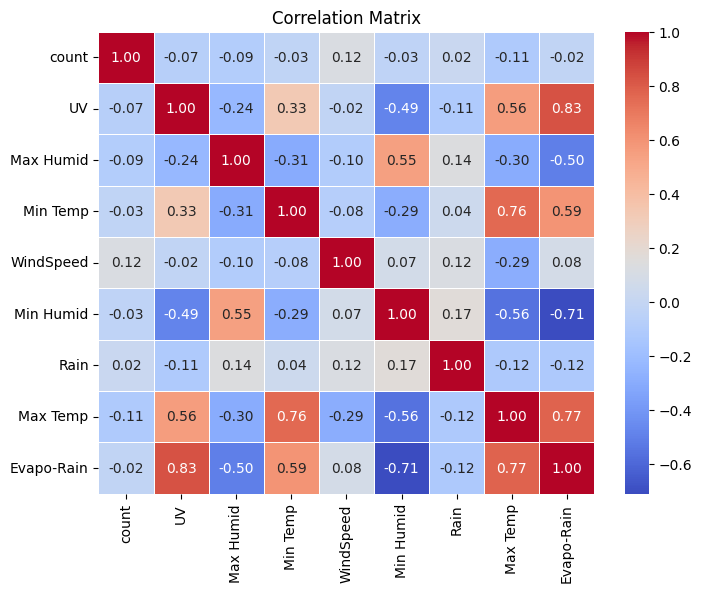

In [11]:
import seaborn as sns
# Select only the numerical columns
numerical_columns = merged_df.select_dtypes(include=[np.number])
# Calculate the correlation between 'count' and the numerical columns
corr_table_pers = numerical_columns.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_table_pers, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [12]:

from scipy.stats import pearsonr
predictor = 'WindSpeed'  # 'UV', 'Min Temp', 'Max Temp', 'WindSpeed', 'Min Humid', 'Max Humid', 'Rain', 'Pan-Rain', 'Evapo-Rain'
r, p_value = pearsonr(numerical_columns[predictor], numerical_columns['count'])
print(f'With a correlation of {r}, the p-value associated to H0:"There is no correlation" is {p_value}')

With a correlation of 0.11838657416979272, the p-value associated to H0:"There is no correlation" is 1.6531436052360867e-43


In [13]:
predictor = 'Max Temp'  # 'UV', 'Min Temp', 'Max Temp', 'WindSpeed', 'Min Humid', 'Max Humid', 'Rain', 'Pan-Rain', 'Evapo-Rain'
r, p_value = pearsonr(numerical_columns[predictor], numerical_columns['count'])
print(f'With a correlation of {r}, the p-value associated to H0:"There is no correlation" is {p_value}')

With a correlation of -0.11099946525421059, the p-value associated to H0:"There is no correlation" is 1.9943961543601192e-38


In [14]:
# Convert 'crash_date' column to datetime in crashes_df_copy if not done already
crashes_df_copy['crash_date'] = pd.to_datetime(crashes_df_copy['crash_date'], dayfirst=True)

# Convert 'Date' column to datetime in weather_df_copy
weather_df_copy['Date'] = pd.to_datetime(weather_df_copy['Date'], dayfirst=True)

merged_df2 = crashes_df_copy.merge(weather_df_copy, left_on=['Station ID', 'crash_date'], right_on=['Station ID', 'Date'], how='inner')

#drop Date and crash_date columns
merged_df2 = merged_df2.drop(['Date', 'crash_date','Station ID', 'location', 'longitude', 'latitude', 'light_condition', ], axis=1)

#rename columns
merged_df2 = merged_df2.rename(columns={"Max Temp": "MaxTemp", "Min Temp": "MinTemp", "Max Humid": "MaxHumid", "Min Humid": "MinHumid", "Evapo-Rain": "EvapoRain"})
merged_df2

,severity,UV,MaxHumid,MinTemp,WindSpeed,MinHumid,Rain,MaxTemp,EvapoRain
0,0,6.06,92,3.5,3.47,55,0.0,14.7,1.2
1,0,6.06,92,3.5,3.47,55,0.0,14.7,1.2
2,1,6.05,94,0.5,2.93,62,0.0,9.8,0.7
3,0,6.05,94,0.5,2.93,62,0.0,9.8,0.7
4,2,6.05,94,0.5,2.93,62,0.0,9.8,0.7
...,...,...,...,...,...,...,...,...,...
46145,3,24.76,99,15.2,4.41,63,0.2,23.4,4.5
46146,0,22.16,94,13.4,2.96,60,0.0,20.3,3.7
46147,0,14.84,97,8.6,6.85,58,0.0,16.3,2.7
46148,1,7.20,98,12.8,7.04,79,0.8,15.8,1.2


In [19]:
# Group by 'crash_date' and sum up 'severity'
crash_severity = crashes_df_copy.groupby(['crash_date','Station ID'])['severity'].sum().reset_index()
crash_severity  = crash_severity.merge(weather_df_copy, left_on=['Station ID', 'crash_date'], right_on=['Station ID', 'Date'], how='inner')
crash_severity

,crash_date,Station ID,severity,UV,Max Humid,Min Temp,WindSpeed,Min Humid,Date,Rain,Max Temp,Evapo-Rain
0,2010-01-01,91237,4,33.91,86,19.2,4.78,31,2010-01-01,0.0,29.7,8.0
1,2010-01-02,91311,0,29.39,94,12.6,6.11,24,2010-01-02,0.2,23.7,6.6
2,2010-01-03,91237,1,32.97,74,9.6,3.28,30,2010-01-03,0.0,24.8,6.3
3,2010-01-03,91311,1,31.70,81,5.9,3.97,28,2010-01-03,0.0,22.9,6.0
4,2010-01-04,91237,1,33.80,85,8.7,4.42,51,2010-01-04,0.0,22.0,5.5
...,...,...,...,...,...,...,...,...,...,...,...,...
13551,2020-01-01,91291,0,16.69,89,5.6,4.55,45,2020-01-01,0.4,20.1,3.8
13552,2020-01-01,94029,0,18.50,58,11.9,6.24,33,2020-01-01,0.0,23.3,6.0
13553,2020-01-01,94087,0,13.36,95,1.7,11.73,65,2020-01-01,0.0,10.1,2.1
13554,2020-01-01,94250,0,23.86,58,11.4,6.63,27,2020-01-01,0.0,24.7,7.0


In [23]:
numerical_columns.columns.tolist()

['count',
 'UV',
 'Max Humid',
 'Min Temp',
 'WindSpeed',
 'Min Humid',
 'Rain',
 'Max Temp',
 'Evapo-Rain']

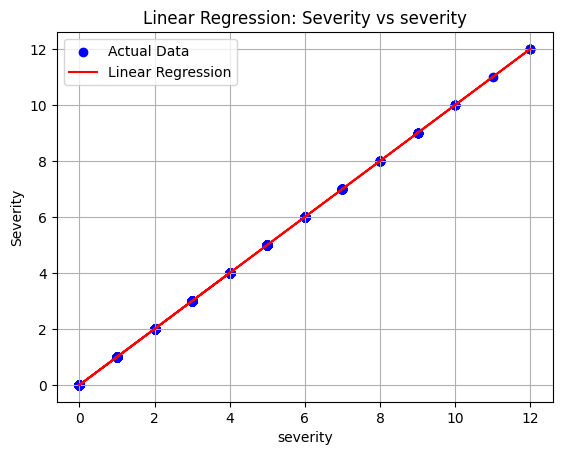

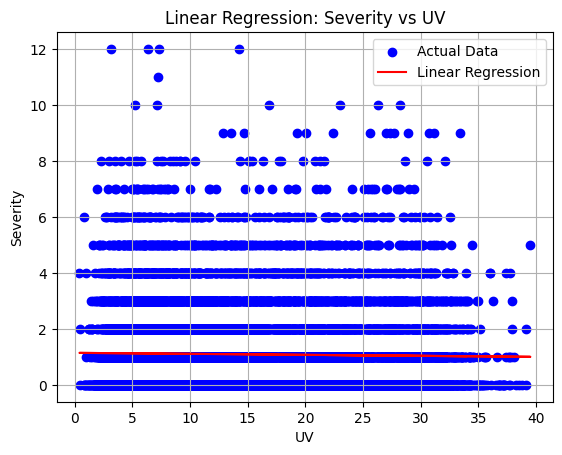

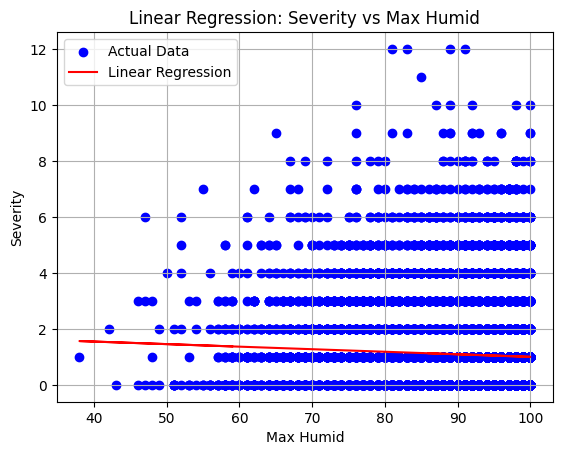

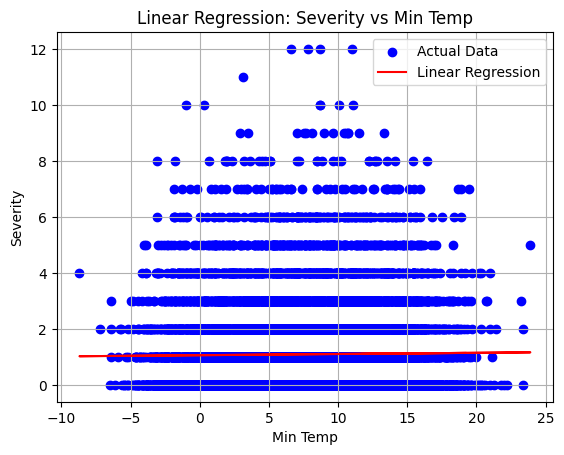

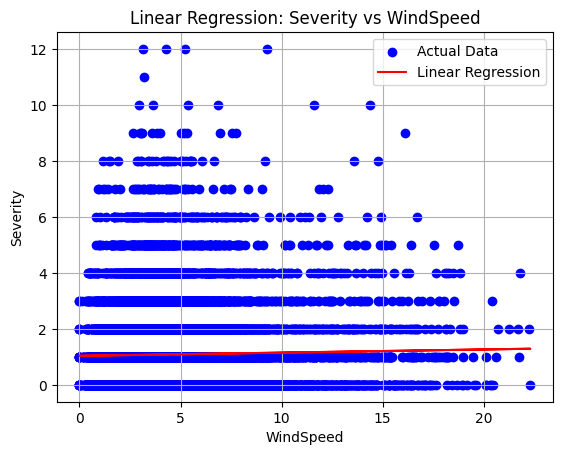

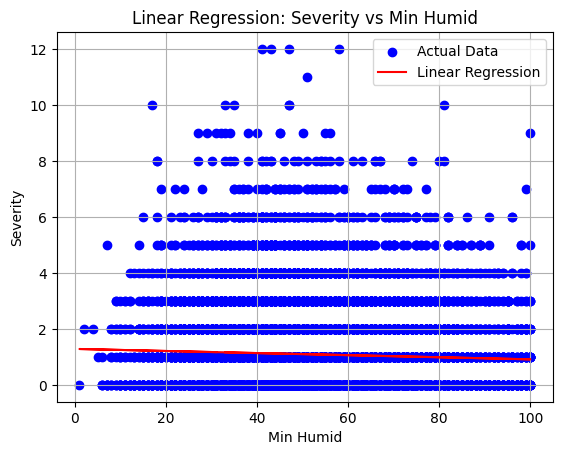

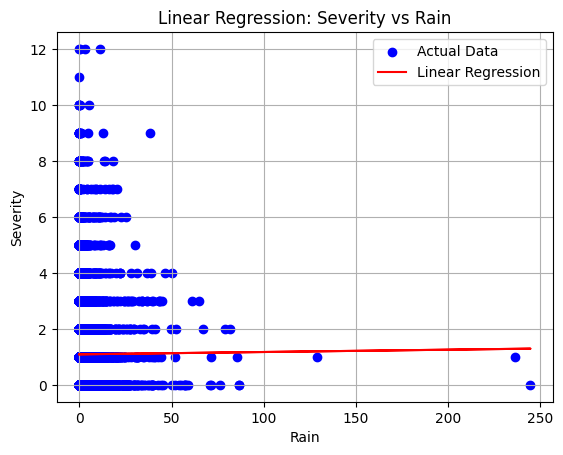

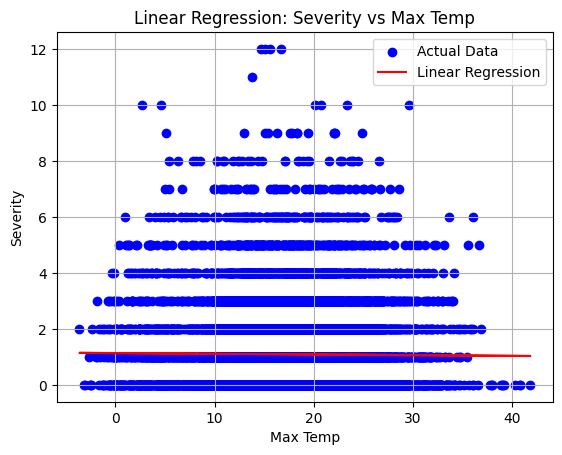

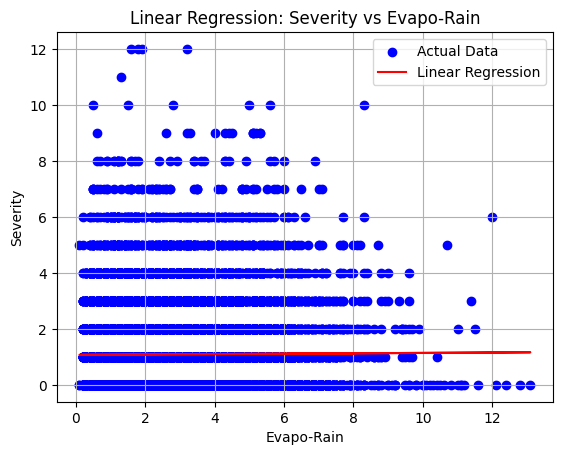

In [25]:
#perform split on the data
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

def linear_analysis(metric_key):
    X = crash_severity[[metric_key]]
    y = crash_severity['severity']
    # Create and fit the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Predict using the fitted model
    y_pred = model.predict(X)

    # Plotting
    plt.scatter(X, y, color='blue', label='Actual Data')
    plt.plot(X, y_pred, color='red', label='Linear Regression')
    plt.title(f'Linear Regression: Severity vs {metric_key}')
    plt.xlabel(metric_key)
    plt.ylabel('Severity')
    plt.legend()
    plt.grid(True)
    plt.show()
# Select only the numerical columns ( all columns except 'severity')
numerical_columns = crash_severity.select_dtypes(include=[np.number])
# Train and evaluate models
for column in numerical_columns.columns.tolist():
    linear_analysis(column)

In [27]:
from sklearn.metrics import r2_score


#X = UV and WindSpeed
X = merged_df[['UV', 'WindSpeed']]
y = merged_df['count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'AdaBoostRegressor': AdaBoostRegressor(),
    'XGBRegressor': XGBRegressor(),
    'CatBoostRegressor': CatBoostRegressor()
    
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'{name} MSE: {mse}')
    r2 = r2_score(y_test, y_pred)
    print(f'{name} R2: {r2}\n')



Linear Regression MSE: 7.698019726745248
Linear Regression R2: 0.021664926308177845

Ridge Regression MSE: 7.69802002098057
Ridge Regression R2: 0.02166488891404983

Lasso Regression MSE: 7.841300064791441
Lasso Regression R2: 0.0034555445376951432

Decision Tree MSE: 15.07019916400295
Decision Tree R2: -0.9152593696845406

Random Forest MSE: 8.971088394857267
Random Forest R2: -0.14012833656239132

GradientBoostingRegressor MSE: 7.679355885544825
GradientBoostingRegressor R2: 0.024036898725025457

AdaBoostRegressor MSE: 9.820049093157028
AdaBoostRegressor R2: -0.2480220620677851

XGBRegressor MSE: 8.444016464877574
XGBRegressor R2: -0.07314319314089057

Learning rate set to 0.058423
0:	learn: 2.8137309	total: 60.3ms	remaining: 1m
1:	learn: 2.8102997	total: 61.5ms	remaining: 30.7s
2:	learn: 2.8079391	total: 62.9ms	remaining: 20.9s
3:	learn: 2.8051950	total: 64ms	remaining: 15.9s
4:	learn: 2.8026642	total: 65.2ms	remaining: 13s
5:	learn: 2.8003288	total: 66.3ms	remaining: 11s
6:	learn: 

In [28]:
# Select only the numerical columns ( all columns except 'severity')
numerical_columns = [col for col in merged_df2.columns if col != 'severity']

from scipy.stats import kruskal

# Perform Kruskal-Wallis H test for each numerical column
def kruskal_test(data, categorical_col, numerical_col):
    groups = data.groupby(categorical_col)[numerical_col].apply(list)
    return kruskal(*groups)

kruskal_results = {col: kruskal_test(merged_df2, 'severity', col) for col in numerical_columns}

# Print Kruskal-Wallis H test results
for col, result in kruskal_results.items():
    print(f'Kruskal-Wallis H test result for {col}:\n', result, '\n')

Kruskal-Wallis H test result for UV:
 KruskalResult(statistic=26.88752715882841, pvalue=2.0947299035746948e-05) 

Kruskal-Wallis H test result for MaxHumid:
 KruskalResult(statistic=3.265696180962305, pvalue=0.5143856998608749) 

Kruskal-Wallis H test result for MinTemp:
 KruskalResult(statistic=15.720430456809073, pvalue=0.003418189780664625) 

Kruskal-Wallis H test result for WindSpeed:
 KruskalResult(statistic=62.00945278408013, pvalue=1.09656033838963e-12) 

Kruskal-Wallis H test result for MinHumid:
 KruskalResult(statistic=7.955504163301394, pvalue=0.09322179974971344) 

Kruskal-Wallis H test result for Rain:
 KruskalResult(statistic=19.92704793376483, pvalue=0.0005162341030858743) 

Kruskal-Wallis H test result for MaxTemp:
 KruskalResult(statistic=66.98425273288818, pvalue=9.823682108324774e-14) 

Kruskal-Wallis H test result for EvapoRain:
 KruskalResult(statistic=16.28327547457715, pvalue=0.002661678914673658) 



# Conclusion
### The significant weather conditions identified (UV, MinTemp, Rain, WindSpeed, MaxTemp, EvapoRain) suggest that certain environmental factors, especially those affecting road conditions and driver performance, are closely associated with crash severity. Specifically:

## Impact of Weather Conditions on Crash Severity
### High UV Levels: May indicate clearer weather and potentially higher speeds, which can lead to more severe crashes due to higher impact forces.
### Low Temperatures: Can result in icy roads, increasing the risk of skidding and losing control, leading to more severe crashes.
### High Wind Speeds: Create driving challenges and hazards, especially for larger vehicles, which can be blown off course, resulting in more severe accidents.
### High Temperatures: Affect tire performance (potentially causing blowouts) and driver fatigue, increasing the likelihood of more severe crashes.
### Rainfall: Leads to wet and slippery roads, reducing traction and increasing stopping distances, which can result in more severe accidents.
### EvapoRain (Evapotranspiration and Rain): Indicates high moisture levels, which can impair visibility and vehicle handling, leading to more severe crashes.

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib
# Assuming X and y are your features and target variable
X = merged_df2[['UV', 'WindSpeed', 'MaxTemp', 'MinTemp', 'Rain', 'EvapoRain']]
y = merged_df2['severity']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'LogisticRegression': LogisticRegression(),
    'K-NearestNeighbors': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier()
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{name} Accuracy: {accuracy:.2f}')
    # Save the model as a pickle file
    joblib.dump(model, f'model_{name}.pkl')
    


LogisticRegression Accuracy: 0.79
K-NearestNeighbors Accuracy: 0.77
DecisionTree Accuracy: 0.74
RandomForest Accuracy: 0.74
